#  GCNs to classify nodes in one big graph.

### Libraries and Configs

In [ ]:
!python -c "import torch; print(torch.version.cuda)"

10.1


In [ ]:
!python -c "import torch; print(torch.__version__)"

1.7.0+cu101


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html


In [ ]:
pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html


In [ ]:
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

In [ ]:
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

In [ ]:
!pip install torch-geometric

In [ ]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html

In [ ]:
import torch
from torch_geometric.data import Data

### Dataset

About the Cora dataset:

- it's one large graph (unlike us, small and more than one graphs)
- which consists of 2708 scientific publications 
- classified into one of seven classes. 
- Each publication in the dataset is described by a 0/1-valued word vector 
  indicating the absence/presence of the corresponding word from the dictionary. 
- The dictionary consists of 1433 unique words (features).

<br>

Nodes = Publications (Papers, Books ...)

Edges = Citations

Node Features = word vectors

7 Labels = Pubilcation e.g. Case_Based, Genetic_Algorithms, Neural_Networks, 
Probabilistic_Methods, Reinforcement_Learning, Rule_Learning, Theory.

<div>
<img src="https://drive.google.com/uc?export=view&id=1-ahz42h98us4awm2CMPAv6s8ZCZfg5Wk" width= "600" />
</div>
Some of the nodes are labeled and some not and must be predicted:

<div>
<img src="https://drive.google.com/uc?export=view&id=1PZ0XJTlFRfyaxfi-koys41nro9kWfc39" width= "600" />
</div>


The features look like this:
<div>
<img src="https://drive.google.com/uc?export=view&id=1aOrucqS0zVE6PdrRnExqZ3wrw0nqD2FO" width= "600" />
</div>



In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Transform is not necessary
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [ ]:
# Get some basic info about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50*'=')

# There is only one graph in the dataset, use it as new data object
data = dataset[0]  

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of validating nodes: {data.val_mask.sum()}')
print(f'Number of testing nodes: {data.test_mask.sum()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True
Number of validating nodes: 500
Number of testing nodes: 1000


In [ ]:
# labels
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [ ]:
# edge connections
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

### Layers

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

torch.manual_seed(42) # the seed ensures that the numbers are reproducible

class Net3(torch.nn.Module):
    def __init__(self):
        super(Net3, self).__init__()

        # Initialize layers
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.out = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index): # x -> node features , 
                                      # edge_index -> edge connectivity,
                                      #               adjacency info

        # Layer 1 
        x = self.conv1(x, edge_index)  
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        
        # Linear Layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return  x


class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        # Initialize layers
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.out = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
       
        # Linear Layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return  x


class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()

        # Initialize layers
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.out = Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        # Linear Layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return  x


Observations:
- Dropout is only applied in the training step, but not for predictions
- We have 3,2,1 Message Passing Layers (3 models) and one Linear output layer
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities, one for each class

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

model1 = Net1().to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)


model2 = Net2().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)


model3 = Net3().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
print(model1)
print(model2)
print(model3)

Net1(
  (conv1): GCNConv(1433, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)
Net2(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)
Net3(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
# Loss Function
criterion = torch.nn.CrossEntropyLoss()

### Training

In [ ]:
loss_1 =[]
for epoch in range(0,701):
      model1.train()
      optimizer1.zero_grad() 
      # Use all data as input, because all nodes have node features
      out = model1(data.x, data.edge_index)  
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward() 
      optimizer1.step()
      loss_1.append(loss)
      if epoch % 100 == 0:
        print(f'Model: 1, Epoch: {epoch:03d}, Loss: {loss:.4f}')

loss_2 =[]
for epoch in range(0,701):
    model2.train()
    optimizer2.zero_grad() 
    # Use all data as input, because all nodes have node features
    out = model2(data.x, data.edge_index)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optimizer2.step()
    loss_2.append(loss)
    if epoch % 100 == 0:
      print(f'Model: 2, Epoch: {epoch:03d}, Loss: {loss:.4f}')

loss_3 =[]
for epoch in range(0,701):
    model3.train()
    optimizer3.zero_grad() 
    # Use all data as input, because all nodes have node features
    out = model3(data.x, data.edge_index)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optimizer3.step()
    loss_3.append(loss)
    if epoch % 100 == 0:
      print(f'Model: 3, Epoch: {epoch:03d}, Loss: {loss:.4f}')

Model: 1, Epoch: 000, Loss: 1.9460
Model: 1, Epoch: 100, Loss: 1.6943
Model: 1, Epoch: 200, Loss: 1.5772
Model: 1, Epoch: 300, Loss: 1.5515
Model: 1, Epoch: 400, Loss: 1.5529
Model: 1, Epoch: 500, Loss: 1.5446
Model: 1, Epoch: 600, Loss: 1.5477
Model: 1, Epoch: 700, Loss: 1.5158
Model: 2, Epoch: 000, Loss: 1.9461
Model: 2, Epoch: 100, Loss: 1.7628
Model: 2, Epoch: 200, Loss: 1.4908
Model: 2, Epoch: 300, Loss: 1.3277
Model: 2, Epoch: 400, Loss: 1.2804
Model: 2, Epoch: 500, Loss: 1.3026
Model: 2, Epoch: 600, Loss: 1.2542
Model: 2, Epoch: 700, Loss: 1.2936
Model: 3, Epoch: 000, Loss: 1.9461
Model: 3, Epoch: 100, Loss: 1.8288
Model: 3, Epoch: 200, Loss: 1.6623
Model: 3, Epoch: 300, Loss: 1.4296
Model: 3, Epoch: 400, Loss: 1.3036
Model: 3, Epoch: 500, Loss: 1.3209
Model: 3, Epoch: 600, Loss: 1.2449
Model: 3, Epoch: 700, Loss: 1.2369


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


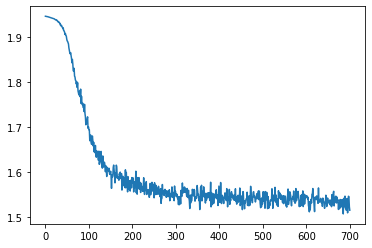

In [ ]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in loss_1] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


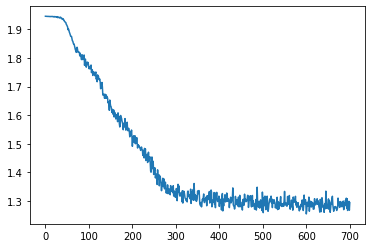

In [ ]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in loss_2] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


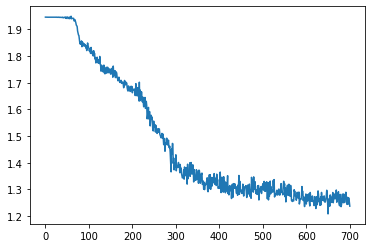

In [ ]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in loss_3] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

### Testing

In [ ]:
model1.eval()
out1 = model1(data.x, data.edge_index)
# Use the class with highest probability.
pred1 = out1.argmax(dim=1)  
# Check against ground-truth labels.
test_correct1 = pred1[data.test_mask] == data.y[data.test_mask]  
# Derive ratio of correct predictions.
test_acc1 = int(test_correct1.sum()) / int(data.test_mask.sum())  

In [ ]:
model2.eval()
out2 = model2(data.x, data.edge_index)
# Use the class with highest probability.
pred2 = out2.argmax(dim=1)  
# Check against ground-truth labels.
test_correct2 = pred2[data.test_mask] == data.y[data.test_mask]  
# Derive ratio of correct predictions.
test_acc2 = int(test_correct2.sum()) / int(data.test_mask.sum())  

In [ ]:
model3.eval()
out3 = model3(data.x, data.edge_index)
# Use the class with highest probability.
pred3 = out3.argmax(dim=1)  
# Check against ground-truth labels.
test_correct3 = pred3[data.test_mask] == data.y[data.test_mask]  
# Derive ratio of correct predictions.
test_acc3 = int(test_correct3.sum()) / int(data.test_mask.sum())  

In [ ]:
print(f'Model 1, Test Accuracy: {test_acc1:.4f}')
print(f'Model 2, Test Accuracy: {test_acc2:.4f}')
print(f'Model 3, Test Accuracy: {test_acc3:.4f}')

Model 1, Test Accuracy: 0.5830
Model 2, Test Accuracy: 0.7770
Model 3, Test Accuracy: 0.7280


## Improving the model
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT ([here](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
- *The* best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)